In [1]:
from __future__ import print_function
from copy import deepcopy
from scipy.io.wavfile import read as wavread
import scipy.signal as signal
from numpy.linalg import norm
import librosa, os, numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from myutils import *

data = []
srs = []
offsets = []
onset_times = []

def getwindow(center, windowsize):
    if type(windowsize) is int:
        return np.arange(center-windowsize, center+windowsize)
    else:
        return np.arange(center+windowsize[0], center+windowsize[1])
    
def tts(t, sr=44100):
        return [int(ts*sr) for ts in t]  if isinstance(t, (tuple, list)) else int(t*sr)

def stt(sample, sr=44100):
    return [s/float(sr) for s in sample] if isinstance(sample, (tuple, list)) else sample/float(sr) 

def newfig(w=40,h=40, **kwargs):
    return plt.figure(figsize=(w,h),**kwargs)


data = []
srs = []
offsets = []
onset_times = []
datadir = os.path.abspath('./data/run_1')
print("Using recordings from %s" % (datadir))
for file in os.listdir(datadir):
    if file.endswith('.wav'):
        (sr,dat) = wavread(os.path.join(datadir,file))
        dat = dat.astype(np.float32)/np.max(dat)
        dat = dat[:,0]
        wh = 500*2*np.pi
        b, a = signal.butter(4, wh, btype='highpass', fs=44100)
        filtdat = signal.filtfilt(b,a,dat)
        filtdat*=np.max(dat)/np.max(filtdat)
        data.append(filtdat)
        srs.append(sr)
        onset_times.append(librosa.onset.onset_detect(np.asfortranarray(filtdat),units="samples",sr=sr, backtrack=False))
        offsets.append(0)
        print("loaded %s" % file)

Using recordings from E:\Dev\acoustic-localization\data\run_1
loaded 1.wav
loaded 2.wav
loaded 3.wav
loaded 4.wav


[-4410, 4410] 2
delay between 0 and 0 (ref) is 0.00001, with stdev 0.000e-3
delay between 1 and 0 (ref) is 0.05196, with stdev 0.000e-3
delay between 2 and 0 (ref) is 0.06667, with stdev 0.019e-3
delay between 3 and 0 (ref) is 0.09338, with stdev 0.016e-3


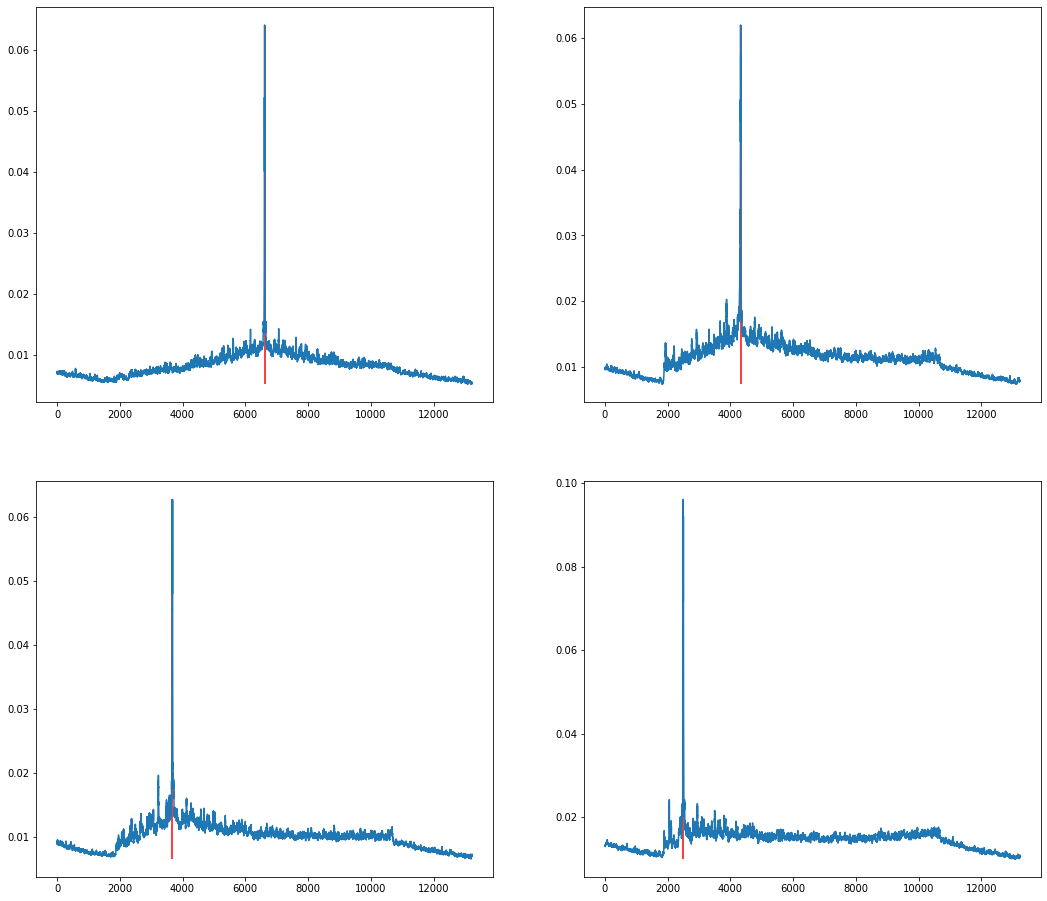

In [2]:
##align files
x_ax_align = [4, 10]
window = [-0.1, 0.1]
ref = 0
temp_offsets = [0 for k in offsets]
print(tts(window), len(tts(window)))
ref_clip = data[ref] 
onsets = onset_times[ref]
onsets = onsets[np.logical_and(onsets >= tts(x_ax_align[0]), onsets <= tts(x_ax_align[1]))]
numonsets = len(onsets)
f = plt.figure(figsize = (18,16))
rc = np.ceil(np.sqrt(len(data)))

for b in range(len(data)):
    delays = np.zeros((numonsets))
    corrs = np.zeros((numonsets))
    delay = 0
    prev_corr = 0
    for ix, onset in enumerate(onsets):
        ref_w = getwindow(onset, tts(0.25))
        ref_clip = data[ref][ref_w]
        b_peak = np.argmax(np.abs(data[b][ref_w]))
        wb = getwindow(onset+tts(offsets[b]), tts(window))
        b_clip = data[b][wb] 
        corr=np.correlate(np.abs(ref_clip),np.abs(b_clip), mode="valid")
        prev_corr = corr/numonsets + prev_corr
        mx = np.argmax(corr)
        delays[ix] = stt(len(corr)/2 - mx)
        delay+=stt(len(corr)/2 - mx)/numonsets
    plt.subplot(rc,rc,b+1)
    plt.plot(corr)
    plt.vlines(np.argmax(corr),np.min(corr),corr[np.argmax(corr)],'r')
    print("delay between %d and %d (ref) is %0.5f, with stdev %.3fe-3" % (b,ref, delay, np.std(delays)*1e3))
    print
    temp_offsets[b]+=delay
offsets = temp_offsets


<Figure size 720x360 with 0 Axes>

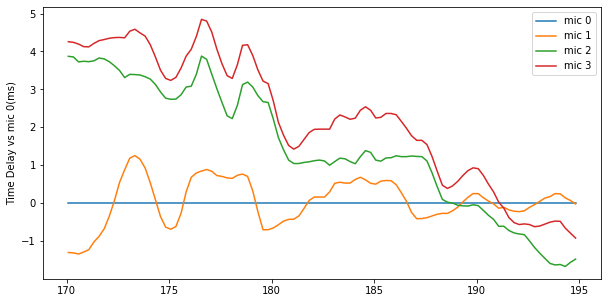

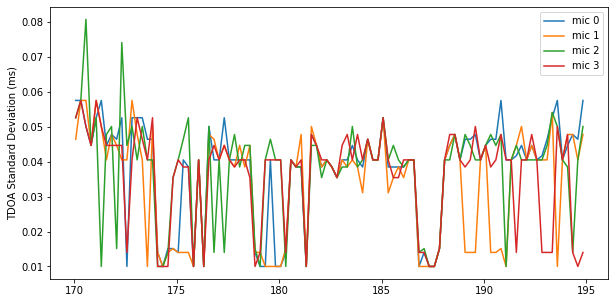

In [3]:
ref = 0
delays = []
times = []
corr_score = []
uncert = []
medians = []

off_data = []
for k in range(len(data)):
    off_data.append(data[k][tts(offsets[k]):])

window = [-0.1, 0.1]
onsets = onset_times[ref]

onsets_in_window = onsets[np.logical_and(onsets >= tts(170), onsets <= tts(195))]
delays = np.zeros((len(onsets_in_window),len(onset_times)), dtype=np.float64)
times = np.zeros((len(onsets_in_window),len(onset_times)),dtype=np.float64)
dts = np.zeros((len(onsets_in_window),len(onset_times),len(onset_times)),dtype=np.float64)
corr_score = np.zeros((len(onsets_in_window),len(onset_times),len(onset_times)))
uncert = np.zeros((len(onsets_in_window),len(onset_times)))
#     medians = np.zeros((len(onsets_in_window),len(onset_times)))
time = stt(onsets_in_window)

for ix, onset in enumerate(onsets_in_window):
    ref_w = getwindow(onset, tts(0.2))
    for r in range(len(data)):
        ref_clip = off_data[r][ref_w]
        for b in range(len(data)):
            b_peak= np.argmax(np.abs(off_data[b][ref_w])) - tts(0.2)
            wb = getwindow(onset+b_peak, tts(window))
            b_clip = off_data[b][wb] 
            corr=np.correlate(np.abs(ref_clip),np.abs(b_clip), mode="valid")
            mx = np.argmax(corr)
            dts[ix,r,b] = stt(mx - tts(0.2))

        times[ix,r] = np.mean(dts[ix,r]) + stt(onset)
        delays[ix,r] = np.mean(dts[ix,r])
        uncert[ix,r] = norm((np.std(dts[ix,r] + stt(onset)), 1e-5))

#plot the results
def plotarray(arr, skipref=False, logscale=False, ylabel=''):
    newfig(h=5,w=10)
    for k in range(arr.shape[1]):
#         if k==ref and skipref:
#             continue
        ln, = plt.plot(times[:,0],arr[:,k])
        plt.yscale('log' if logscale else 'linear')
        label = "mic " + str(k)
        ln.set_label(label)
    plt.ylabel(ylabel)
    plt.legend()


newfig(h=5,w=10)
rc = np.ceil(np.sqrt(len(data)))
newdelays = np.zeros(delays.shape)
for a in range(len(data)):
    newdelays[:,a] = delays[:,a] - delays[:,0]
plotarray(newdelays*1e3, skipref=True, ylabel="Time Delay vs mic 0(ms)")
plt.show()
plotarray(uncert*1e3, ylabel="TDOA Standard Deviation (ms)")

In [4]:


w = 65.5*.0254
h = 30.5*.0254
t_uncert = 1e-4
mmics = ([0,h],[0,0],[w,h],[w,0])
# anss = np.zeros((delays.shape[0],3))
time = times[:,0]
# angles = np.zeros((delays.shape[0],))
poses = np.zeros((delays.shape[0],2))
posuncert = np.zeros((delays.shape[0],2))
uninformed_guess = [0.5, 0.5]
prev_good = 0

for k in range(times.shape[0]):
    guess = uninformed_guess if not prev_good else poses[k-1]
    ans = solve(mmics,times[k],guess)
    poses[k] = ans.x
    unc = np.array([])
    for a in range(len(mmics)-1):
        for b in range(a+1,len(mmics)):
            unc = np.append(unc,norm([duncert(poses[k,0], poses[k,1], mmics[a][0],mmics[a][1],mmics[b][0],mmics[b][1],0.05),uncert[k,a],uncert[k,b]]))
    xunc = norm(ans.jac[:,0]*unc)
    yunc = norm(ans.jac[:,1]*unc)
    posuncert[k] = np.array([xunc,yunc])
#     anss[k] = ans

Text(0, 0.5, 'Uncertainty (mm)')

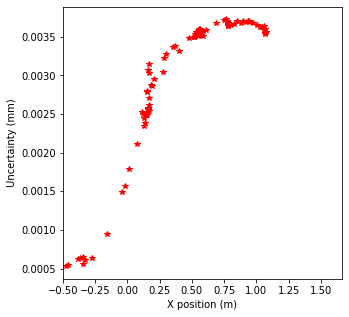

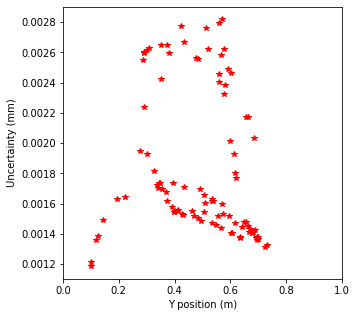

In [5]:
newfig(5,5)
plt.plot(poses[:,0],posuncert[:,0]*1e3,'*r')
plt.xlim([-0.5,w])
plt.xlabel('X position (m)')
plt.ylabel('Uncertainty (mm)')
# plt.ylim([-0.5,h])
newfig(5,5)
plt.plot(poses[:,1],posuncert[:,1]*1e3,'*r')
plt.xlim([0,1])
plt.xlabel('Y position (m)')
plt.ylabel('Uncertainty (mm)')

In [7]:
# from matplotlib.widgets import Slider
def redraw(t=0, window=10):
    plt.figure(figsize=(10,10))
    plt.vlines([0,w],0,h,'k')
    plt.hlines([0,h],0,w,'k')
    ix = np.argmax(time>t)
    a = 1
    while ix > 0 and a> 0.1:
        poss = poses[ix:ix+window+1] 
        plt.plot(poss[:,0], poss[:,1], alpha=a, linewidth=4, color = '#4b0082')
        ix-=window
        a*=0.9
    bw = 0.25
    plt.xlim([-bw,w+bw])
    plt.ylim([-bw,h+bw])
    plt.gca().set_aspect(1)

ts = times[0,0]    
btn=widgets.Button(description='reset t range')

intr = interactive(redraw, t=(ts,times[-1,0]), window=(0,50))
# def reset(*args):
#     tslide = intr.children[0]
#     tslide.min=tslide.value
#     tslide.max=tslide.value+50
# btn.on_click(reset)
display(btn,intr)

Button(description='reset t range', style=ButtonStyle())

interactive(children=(FloatSlider(value=170.07649659863947, description='t', max=194.8284013605442, min=170.07…

In [13]:
#MLE
rscale = 1000
mics = ([0,h],[0,0],[w,h],[w,0])
x_range,xstep = np.linspace(0,w,int(100*w),retstep=True)
y_range,ystep = np.linspace(0,h,int(100*h),retstep=True)
X,Y = np.meshgrid(x_range,y_range)
def f(t):
    print(t)
    res = 100
    mics = ([0,h],[0,0],[w,h],[w,0])
    x_range,xstep = np.linspace(0.001,w-0.001,int(res*w),retstep=True)
    y_range,ystep = np.linspace(0.001,h-0.001,int(res*h),retstep=True)
    jpdf = np.zeros(X.shape)
#     print(X.shape)
    individual = [np.zeros(X.shape) for k in range(6)]
    ind = 0
    for a in range(len(mics)-1):
        for b in range(a+1,len(mics)):
#             ut = norm((uncert[t,b], uncert[t,a]))
            
            dt_meas = times[t,b] - times[t,a]
            for ix,x in enumerate(x_range):
                for iy, y in enumerate(y_range):
                    ut = duncert(x,y,mics[a][0], mics[a][1],mics[b][0],mics[b][1],0.05)
                    pos = np.array([x,y])
                    dt_calc = tdoa(pos, (mics[a],mics[b]))
                    p = np.exp(((dt_meas-dt_calc)/ut)**2*(-1/2))
                    individual[ind][iy,ix] = p
            ind+=1
    jpdf = np.prod(individual,0)
    for a in range(6):
        newfig(10,10)
        plt.pcolor(X,Y,individual[a], cmap='YlGnBu_r')
        plt.gca().set_aspect(1)
    plt.figure(figsize=(10,40))
    plt.pcolor(X,Y,jpdf, cmap='YlGnBu_r')
    plt.title("Joint PDF")
    plt.gca().set_aspect(1)
    amax = np.argmax(jpdf)
    (xi,yi) = np.unravel_index(amax,jpdf.shape)
    print("max at: ", xi*xstep,yi*ystep, amax)
    return (xi*xstep,yi*ystep)
    
interactive(f,t=(0,times.shape[0]))

interactive(children=(IntSlider(value=50, description='t'), Output()), _dom_classes=('widget-interact',))